<a href="https://colab.research.google.com/github/GrE3lzzz/Gittea/blob/main/drive_me_crazy_pdformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Propagation Delay-Aware Transformer
class PropagationDelayTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim):
        super(PropagationDelayTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=num_heads, num_encoder_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x, x)
        x = self.fc_out(x[:, -1, :])
        return x

# Heatmap Generation Function
def generate_heatmap(data, x_label, y_label, title, filename):
    """
    Generates and saves a heatmap for the given data.

    Parameters:
        data (pd.DataFrame): Data containing columns for x, y, and values.
        x_label (str): Column name for x-axis.
        y_label (str): Column name for y-axis.
        title (str): Title of the heatmap.
        filename (str): Output CSV filename.
    """
    # Pivot the data for heatmap visualization
    heatmap_data = data.pivot(index=y_label, columns=x_label, values="Correlation")

    # Save heatmap data to CSV for Looker Studio
    heatmap_data.to_csv(filename, index=True)
    print(f"Heatmap data saved as '{filename}'.")

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(title)
    plt.show()

In [ ]:
# Load preprocessed dataset
preprocessed_data = pd.read_csv("/content/drive/MyDrive/preprocessed_traffic_data.csv")

# Prepare data for training
# Convert 'time' column to numerical representation if it's not already
preprocessed_data['time'] = pd.to_datetime(preprocessed_data['time']).astype(np.int64) // 10**9
X = preprocessed_data.drop(columns=['traffic_volume']).values
y = preprocessed_data['traffic_volume'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize and train the transformer model
input_dim = X_train.shape[1]
model = PropagationDelayTransformer(input_dim=input_dim, num_heads=4, num_layers=2, hidden_dim=64)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# Train model
print("Training the Propagation Delay-Aware Transformer...")
for epoch in range(10):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X.unsqueeze(1))
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluate the model
print("Evaluating the model...")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    predictions = model(X_test_tensor.unsqueeze(1)).numpy()

transformer_mae = mean_absolute_error(y_test, predictions)
transformer_rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Transformer Model Evaluation Metrics:\nMAE: {transformer_mae}, RMSE: {transformer_rmse}")

Training the Propagation Delay-Aware Transformer...
Epoch 1, Loss: 0.016587907448410988
Epoch 2, Loss: 0.016086921095848083
Epoch 3, Loss: 0.014111081138253212
Epoch 4, Loss: 0.011831071227788925
Epoch 5, Loss: 0.016340816393494606
Epoch 6, Loss: 0.009224492125213146
Epoch 7, Loss: 0.006139613222330809
Epoch 8, Loss: 0.006535919848829508
Epoch 9, Loss: 0.007668731268495321
Epoch 10, Loss: 0.011845992878079414
Evaluating the model...
Transformer Model Evaluation Metrics:
MAE: 0.07617070221984958, RMSE: 0.0935488530509689


Traffic predictions and metrics saved as 'traffic_predictions_and_metrics.csv'.
Daily aggregated traffic volume saved as 'daily_traffic_volume.csv'.
Heatmap data saved as 'propagation_delay_heatmap.csv'.


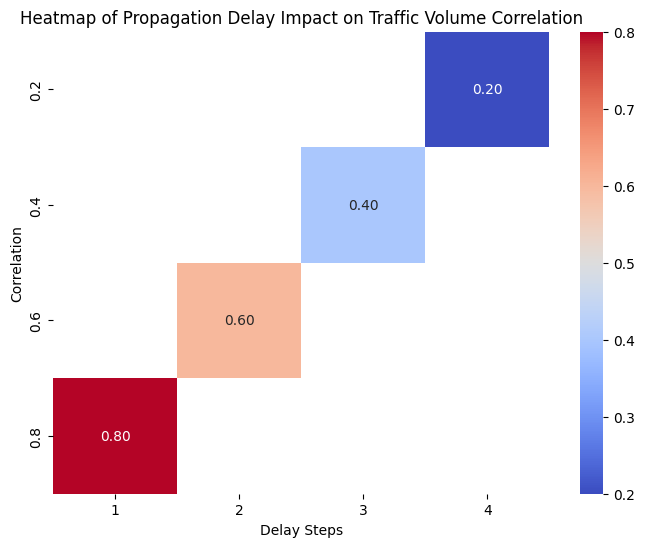

In [ ]:
# Combine predictions and actual values into a DataFrame for Looker Studio
results_df = pd.DataFrame({
    "Timestamp": preprocessed_data['time'].iloc[:len(X_test)].values,
    "Actual Traffic Volume": y_test,
    "Predicted Traffic Volume": predictions.flatten(),
    "Model": "Transformer",
    "MAE": transformer_mae,
    "RMSE": transformer_rmse
})

# Save results to CSV for Looker Studio
results_df.to_csv("traffic_predictions_and_metrics.csv", index=False)
print("Traffic predictions and metrics saved as 'traffic_predictions_and_metrics.csv'.")

# Aggregate daily traffic volume for visualization
aggregated_data = pd.DataFrame({
    'Timestamp': pd.to_datetime(preprocessed_data['time'], unit='s'),
    'Traffic Volume': preprocessed_data['traffic_volume']
})

daily_aggregated = aggregated_data.resample('D', on='Timestamp').mean().reset_index()
daily_aggregated.to_csv("daily_traffic_volume.csv", index=False)
print("Daily aggregated traffic volume saved as 'daily_traffic_volume.csv'.")

# Generate Heatmap for Propagation Delay Analysis
# Example delay_results: Simulated data showing correlation with propagation delays
delay_results = pd.DataFrame({
    "Delay Steps": [1, 2, 3, 4],
    "Correlation": [0.8, 0.6, 0.4, 0.2]
})

generate_heatmap(
    data=delay_results,
    x_label="Delay Steps",
    y_label="Correlation",
    title="Heatmap of Propagation Delay Impact on Traffic Volume Correlation",
    filename="propagation_delay_heatmap.csv"
)

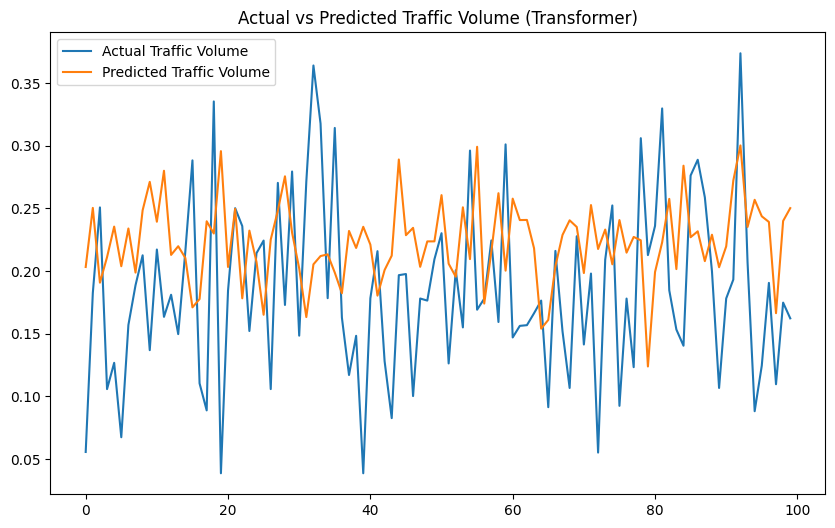

Transformer model saved as 'transformer_model.pth'.


In [ ]:
# Visualize predictions vs actual values (optional)
plt.figure(figsize=(10, 6))
plt.plot(y_test[:100], label="Actual Traffic Volume")
plt.plot(predictions[:100], label="Predicted Traffic Volume")
plt.legend()
plt.title("Actual vs Predicted Traffic Volume (Transformer)")
plt.show()

# Save model
torch.save(model.state_dict(), "transformer_model.pth")
print("Transformer model saved as 'transformer_model.pth'.")